In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

### Read data

In [153]:
raw = pd.read_csv('./5-scalar-helpfulness-mturk-results.csv')

### Flatten data

In [154]:
data = []
for i,row in raw.iterrows():
    for j in range(1, 13):
        query = row['Input.q%d' % j]
        response = row['Input.r%d' % j]
        gender = row['Input.g%d' % j]
        
        if row['Answer.answer%d' % j] is not np.nan:
            answer = row['Answer.answer%d' % j]
        else:
            answer = row['Answer.answer%d.label' % j]
        
        data.append((row['HITId'], j, row['WorkerId'], gender, query, response, answer))

In [155]:
melted = pd.DataFrame(data)
melted.columns = ['HITId', 'q_idx', 'WorkerId', 'gender', 'query', 'response', 'answer']
melted.head(1)

,HITId,q_idx,WorkerId,gender,query,response,answer
0,3NZ1E5QA6Z25J0NR6OZ9SXGHG515BO,1,ARPBDM5QZ4XQC,W,How did you get to swim with them!?,I've never been to a swimming pool.,Unhelpful


In [156]:
# include spammers:
include = True
if not include:
    spammers = ['A304UJAE051J89']
    melted = melted[~melted.WorkerId.isin(spammers)].copy()

In [157]:
data = []
for i, group in melted.groupby(['HITId', 'q_idx']):
    row = []
    row.append(group.iloc[0]['HITId'])
    row.append(group.iloc[0]['gender'])
    row.append(group.iloc[0]['query'])
    row.append(group.iloc[0]['response'])
    for j in range(0,2):
        if j < len(group):
            row.append(group.iloc[j]['WorkerId'])
            row.append(group.iloc[j]['answer'])
    data.append(row)

In [158]:
flat = pd.DataFrame(data)
flat.columns = ['HITId', 'gender', 'query', 'response'] + \
    sum([ ['WorkerId%d' % i, 'answer%d' % i] for i in range(0,2) ], [])

In [159]:
flat.head(1)

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1
0,33P2GD6NRNTISWBGD3DBGX2X881HK1,W,how do you put a dollar amount on sleep depriv...,"Buy a pillow, make sure it doesn't fall asleep...",A304UJAE051J89,Unhelpful,A2488KXHWJTJR7,Helpful


### Collapse labels

In [160]:
flat.answer0.unique()

array(['Unhelpful', 'Very helpful', 'Helpful', 'Very Unhelpful',
       'Neutral', nan], dtype=object)

In [161]:
def mapping(x):
    if type(x) == str:
        x = x.lower()
        l = ['very helpful', 'helpful', 'neutral', 'unhelpful', 'very unhelpful']
        return 4 - l.index(x)
    else:
        print('error')
        return 2

In [162]:
melted['scale'] = melted.answer.apply(lambda x: mapping(x))

error


### Analysis

In [163]:
groups = melted.groupby('gender').scale.mean()
print(groups)
difference = groups['W'] - groups['M']
print(difference)

gender
M    2.137725
W    2.313472
Name: scale, dtype: float64
0.1757469516924699


In [164]:
melted.std()['scale']

1.2692277928856384

##### Plot

<AxesSubplot:xlabel='gender', ylabel='scale'>

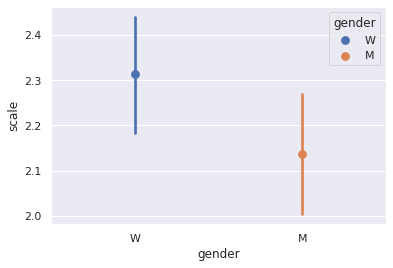

In [165]:
sns.pointplot(x='gender', y='scale', data=melted, hue='gender')

##### t-test

In [166]:
from scipy.stats import ttest_ind
groups = list(melted.groupby('gender'))
m_group, w_group = groups[0], groups[1]
ttest_ind(m_group[1]['scale'], w_group[1]['scale'])

Ttest_indResult(statistic=-1.8560342776183485, pvalue=0.06385818408263078)

##### Number of workers

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


30


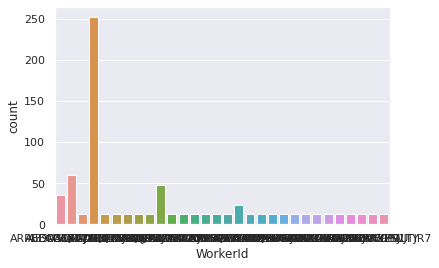

In [167]:
sns.countplot(melted['WorkerId'], orient='v')
print(len(melted['WorkerId'].value_counts()))

##### pooled variance

In [182]:
import random
flat['scale0'] = flat.answer0.apply(lambda x: mapping(x))
flat['scale1'] = flat.answer1.apply(lambda x: mapping(x) + random.uniform(0,0.4))
flat.head(1)

error


,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,scale0,scale1
0,33P2GD6NRNTISWBGD3DBGX2X881HK1,W,how do you put a dollar amount on sleep depriv...,"Buy a pillow, make sure it doesn't fall asleep...",A304UJAE051J89,Unhelpful,A2488KXHWJTJR7,Helpful,1,3.082048


<AxesSubplot:xlabel='scale0', ylabel='scale1'>

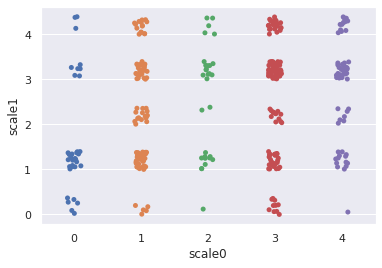

In [183]:
sns.stripplot(data=flat, x='scale0', y='scale1')

In [187]:
pooled_var = np.mean(np.sqrt(flat['scale0'] - flat['scale1']))
np.sqrt(pooled_var)

1.094757871512066